# Artificial Bee Colony (ABC) for the TSP

### Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial import distance # for euclidian distance

import ArtificialBeeColony_TSP

### Read dataset

The data that we are going to use in this proyect will be obtein from a web call [National TSP](https://www.math.uwaterloo.ca/tsp/world/countries.html) from the University of Waterloo.

This website was created to collect large-scale data on the Travel Seller Problem from different countries. In each country you can find a different number of cities which are represented with their X and Y coordinates. The **cost of traveling between cities is specified by the Euclidean distance** rounded to the nearest whole number.

In this case we are going to work with the dataset of the country Luxembourg, which conteins 980 cities but there are some cities duplicated, so in the end there are **634 cities**.

The web provides some information of the best solution provide until now for the problem, such as:
* **Optimal value (min path distance):** 11340
* **Algorithm:** concorde (default settings), QSopt LP solver
* **Time:** 1681.68 seconds, AMD Athlon 1.33 GHz

In [2]:
cities = pd.read_csv("lu980.tsp", sep=" ", skiprows=7, header=None, names=["Coord X", "Coord Y"])
cities = cities.iloc[:-1]
print("In our dataset there are {0} cities".format(cities.shape[0]))
cities

In our dataset there are 980 cities


,Coord X,Coord Y
1,49525.5556,5940.5556
2,49525.5556,5940.5556
3,49738.8889,6345.0000
4,49608.3333,6405.8333
5,49796.6667,6155.5556
...,...,...
976,50108.0556,5923.3333
977,49880.2778,6221.9444
978,49894.4444,6163.6111
979,49926.6667,6173.6111


### Clean dataset

In [3]:
cities_duplicated = cities.duplicated().sum()
print("Number of duplicated cities: ", cities_duplicated)

cities = cities.drop_duplicates()
cities = cities.reset_index(drop=True)
print("In our dataset there are {0} cities after delating the duplicated cities".format(cities.shape[0]))

Number of duplicated cities:  346
In our dataset there are 634 cities after delating the duplicated cities


### Create matrix distance between cities

In [4]:
distance_matrix = np.round(distance.cdist(cities, cities, 'euclidean')).astype(int)
print("Shape distance matrix: ", distance_matrix.shape)
distance_matrix

Shape distance matrix:  (634, 634)


array([[  0, 457, 473, ..., 162, 414, 402],
       [457,   0, 144, ..., 355, 208, 501],
       [473, 144,   0, ..., 332,  93, 614],
       ...,
       [162, 355, 332, ...,   0, 261, 490],
       [414, 208,  93, ..., 261,   0, 617],
       [402, 501, 614, ..., 490, 617,   0]])

### Other functions

In [5]:
def plot_path(path, cities):
    path_cities = cities.loc[path]
    plt.scatter(path_cities['Coord X'], path_cities['Coord Y'], color='red')
    plt.plot(path_cities['Coord X'], path_cities['Coord Y'], color='blue')
    plt.xlabel('Coord X')
    plt.ylabel('Coord Y')
    plt.show()
    

In [6]:
def history_best_paths_distances(paths_distances, employed_strategy, onlooker_strategy, xlabel='Iteraciones', ylabel='Best path distances', title='Evolution of path distances'):
    plt.plot(paths_distances)
    plt.scatter(np.argmin(paths_distances), np.min(paths_distances), color='red')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend([f'Min distance: {np.min(paths_distances)}'])
    plt.text(1.05, 0.5, 
         f"Employed strategy:\n{employed_strategy}\n\n"
         f"Onlooker strategy:\n{onlooker_strategy}",
         transform=plt.gca().transAxes,
         verticalalignment='center', 
         horizontalalignment='left',
         fontsize=10,
         fontstyle='normal',
         bbox=dict(facecolor='#f0f0f0', edgecolor='gray', boxstyle='round,pad=0.5', alpha=0.9))
    plt.show

In [7]:
def plot_comparison(best_solution, other_solution):
    best_time, best_path_distance = best_solution
    time, path_distance = other_solution

    time_loss = ((time - best_time) / best_time) * 100
    distance_loss = ((path_distance - best_path_distance) / best_path_distance) * 100
    
    categories_x = ['Execution Time', 'Path Distance']
    categories_y = ['Seconds', 'Distance']
    best_values = [best_time, best_path_distance]
    other_values = [time, path_distance]
    losses = [time_loss, distance_loss]
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    bar_width = 0.15
    index = np.arange(len(categories_x))
    
    # Create all bars for the data
    axes[0].bar(index[0] - bar_width/2, best_values[0], bar_width, color='darkblue', label='Best Solution')
    axes[0].bar(index[0] + bar_width/2, other_values[0], bar_width, color='dodgerblue', label='Other Solution')

    axes[1].bar(index[1] - bar_width/2, best_values[1], bar_width, color='darkblue', label='Best Solution')
    axes[1].bar(index[1] + bar_width/2, other_values[1], bar_width, color='dodgerblue', label='Other Solution')

    # Add the porcentaje of difference into other solution bar
    axes[0].text(index[0] + bar_width/2, other_values[0] + 0.05 * best_values[0], f'{losses[0]:.1f}%', ha='center', va='bottom', fontsize=12)
    axes[1].text(index[1] + bar_width/2, other_values[1] + 0.05 * best_values[1], f'{losses[1]:.1f}%', ha='center', va='bottom', fontsize=12)
    
    # Set the limints of the axe x to plot both bars in the middle
    axes[0].set_xlim(index[0] - bar_width * 3, index[0] + bar_width * 3)
    axes[1].set_xlim(index[1] - bar_width * 3, index[1] + bar_width * 3)

    for i, ax in enumerate(axes):
        ax.set_xlabel(categories_x[i])
        ax.set_ylabel(categories_y[i])
        ax.set_xticks([])
        ax.legend()

    axes[0].set_title('Execution Time Comparison')
    axes[1].set_title('Path Distance Comparison')
    
    plt.tight_layout()
    plt.show()

In [8]:
def info_training(block_size, paths_distances):
    improvements = []
    percent_improvements = []

    for block_ini in range(0, len(paths_distances)-block_size, block_size):
        block_end = block_ini + block_size

        start_distance_path = paths_distances[block_ini]
        end_distance_path = paths_distances[block_end]

        improvement_distance = start_distance_path- end_distance_path
        percentaje_improvement = (improvement_distance / start_distance_path) * 100

        print(f"Iterations {block_ini}-{block_end-1}: Improvement of {improvement_distance:.2f} units of distance "
          f"({percentaje_improvement:.2f}%)")

        improvements.append(improvement_distance)
        percent_improvements.append(percentaje_improvement)

    total_improvement = paths_distances[0] - paths_distances[-1]
    total_percent_improvement = (total_improvement / paths_distances[0]) * 100
    print(f"\nTotal improvement over the entire training: {total_improvement:.2f} units of distance "
        f"({total_percent_improvement:.2f}%)")
    
    block_indices = np.arange(len(improvements)) * block_size

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(block_indices, improvements, marker='o', color='blue')
    plt.title('Improvement by Block (Absolute)')
    plt.xlabel('Iterations')
    plt.ylabel('Improvement (units of distance)')
    plt.grid(True)
    plt.xticks(block_indices[::2])

    plt.subplot(1, 2, 2)
    plt.plot(block_indices, percent_improvements, marker='o', color='green')
    plt.title('Improvement by Block (Percentage)')
    plt.xlabel('Iterations')
    plt.ylabel('Improvement (%)')
    plt.grid(True)
    plt.xticks(block_indices[::2])

    for i, txt in enumerate(percent_improvements):
        plt.text(block_indices[i], percent_improvements[i], f'{txt:.2f}%', fontsize=7, ha='left', va='bottom')

    plt.tight_layout()
    plt.show()

In [47]:
import random
import itertools
import time
random.seed(1234)

num_cities = distance_matrix.shape[0]
other_cities = np.delete(np.arange(num_cities), 0)
random_path = np.insert(np.random.permutation(other_cities), [0, len(other_cities)], 0)

path = random_path[:]
len_path = len(path) - 2
k = 3

random_index = sorted(random.sample(range(1, len_path), k))

start = time.time()
for _ in range(10000):
    

    segments = [path[:random_index[0]+1]]
    segments.extend([path[random_index[i]+1:random_index[i+1]+1] for i in range(k-1)])
    segments.append(path[random_index[-1]+1:])

    middle_segments = [[segmento, segmento[::-1]] for segmento in segments[1:-1]]

    possible_permutations = list(itertools.product(*middle_segments)) + list(itertools.product(*middle_segments[::-1]))
    
    new_path = [np.concatenate((segments[0], *perm, segments[-1])) for perm in possible_permutations]
    new_path_1 = new_path[1:]
end = time.time()
print(end-start)
#print(new_path_1)

start = time.time()
for _ in range(10000):

    segments = [path[:random_index[0]+1]]
    segments.extend([path[random_index[i]+1:random_index[i+1]+1] for i in range(k-1)])
    segments.append(path[random_index[-1]+1:])

    middle_segments = [[segmento, segmento[::-1]] for segmento in segments[1:-1]]

    possible_permutations = list(itertools.product(*middle_segments)) + list(itertools.product(*middle_segments[::-1]))
    
    new_path = [np.concatenate((segments[0], *perm, segments[-1])) for perm in possible_permutations]
    new_path_3 = new_path[1:]
end = time.time()
print("\n", end-start)
#print(new_path_3)

print(np.array_equal(new_path_1,new_path_3))

0.10464978218078613

 0.10375690460205078
True


In [39]:
path = [1,2,3,4,5,6,7,8,9,1]
len_path = len(path) - 2
k = 4

random_index = [2,4,6,7]

segments = [path[:random_index[0]+1]]
segments.extend([path[random_index[i]+1:random_index[i+1]+1] for i in range(k-1)])
segments.append(path[random_index[-1]+1:])
print(segments)

middle_segments = [[segmento, segmento[::-1]] for segmento in segments[1:-1]]
print(middle_segments)
"""
possible_permutations = list(itertools.product(*middle_segments)) + list(itertools.product(*middle_segments[::-1]))
"""
possible_permutations = list(itertools.chain(
            itertools.product(*middle_segments),
            itertools.product(*[seg[::-1] for seg in middle_segments])
        ))

print(possible_permutations)

new_path = [np.concatenate((segments[0], *perm, segments[-1])) for perm in possible_permutations]
new_path = new_path[1:]
print(new_path)

[[1, 2, 3], [4, 5], [6, 7], [8], [9, 1]]
[[[4, 5], [5, 4]], [[6, 7], [7, 6]], [[8], [8]]]
[([4, 5], [6, 7], [8]), ([4, 5], [6, 7], [8]), ([4, 5], [7, 6], [8]), ([4, 5], [7, 6], [8]), ([5, 4], [6, 7], [8]), ([5, 4], [6, 7], [8]), ([5, 4], [7, 6], [8]), ([5, 4], [7, 6], [8]), ([5, 4], [7, 6], [8]), ([5, 4], [7, 6], [8]), ([5, 4], [6, 7], [8]), ([5, 4], [6, 7], [8]), ([4, 5], [7, 6], [8]), ([4, 5], [7, 6], [8]), ([4, 5], [6, 7], [8]), ([4, 5], [6, 7], [8])]
[array([1, 2, 3, 4, 5, 6, 7, 8, 9, 1]), array([1, 2, 3, 4, 5, 7, 6, 8, 9, 1]), array([1, 2, 3, 4, 5, 7, 6, 8, 9, 1]), array([1, 2, 3, 5, 4, 6, 7, 8, 9, 1]), array([1, 2, 3, 5, 4, 6, 7, 8, 9, 1]), array([1, 2, 3, 5, 4, 7, 6, 8, 9, 1]), array([1, 2, 3, 5, 4, 7, 6, 8, 9, 1]), array([1, 2, 3, 5, 4, 7, 6, 8, 9, 1]), array([1, 2, 3, 5, 4, 7, 6, 8, 9, 1]), array([1, 2, 3, 5, 4, 6, 7, 8, 9, 1]), array([1, 2, 3, 5, 4, 6, 7, 8, 9, 1]), array([1, 2, 3, 4, 5, 7, 6, 8, 9, 1]), array([1, 2, 3, 4, 5, 7, 6, 8, 9, 1]), array([1, 2, 3, 4, 5, 6, 7, 8, 9,

### Train ABC model

In [51]:
ini_end_city = 0

population = 50
employed_porcentaje = 0.2
onlooker_percentaje = 0.8
limit = 2000
epochs = 50000

employed_mutation_strategy = 'k_opt'    # swap, insertion, k_opt
onlooker_mutation_strategy = 'k_opt'    # swap, insertion, k_opt
k_employed = 6
k_onlooker = 6

ABC = ArtificialBeeColony_TSP.ArtificialBeeColonyOptimizer(ini_end_city, population, employed_porcentaje, limit, epochs, distance_matrix, 
                                                           employed_mutation_strategy, onlooker_mutation_strategy, k_employed, k_onlooker)

execution_time, paths_distances, final_best_path, final_best_path_distance = ABC.fit()
print(len(final_best_path))

Training Progress: 100%|██████████| 50000/50000 [16:34<00:00, 50.27epoch/s]

Params:
	(ini_end_city=0, population=50, epochs=50000, limit=2000, employed_percentage=0.2, onlooker_percentage=0.8)

Min path distance:  13932
The best path found is: 
 [  0 441 510  83 100 224 117 213 629 212 294 174 135 144 141 310 282  22
 513 190 605 483 497 240 474 109 448 168 296 591 157 498  19 597  79 203
  66 123 338 543 353 500 631 541 588 361 465 630 300 107 138 592  72 253
 531 440  29 323 603 291 176 317 136 579 385 464 622 352 564  30 527 285
 375 295 132  86 601 608 495 234  12 172 442 404 456 463 119   8  88 225
 261  99 183  57  97 229 219 198 367 159 356 271 575 493 378 417 162 226
 332 508 389  44 393 233  75 548 319  13 554 335 256  58 547 326 536 439
 557 414 454 580 246 189 249  51 115 154 351 412 517 252 396 397 193 214
 114 336 615  25 537 432 264 509 147 171  69 572 428 542 473 222 476 384
 418 315 262 220 354 409 340 286 565 298 633 260 199 594  11 204 545 516
 555 472 480  36  14 208 124 521 206 254 339 626 303  15 169  87 503 230
 573 227 505 268 140 504 36

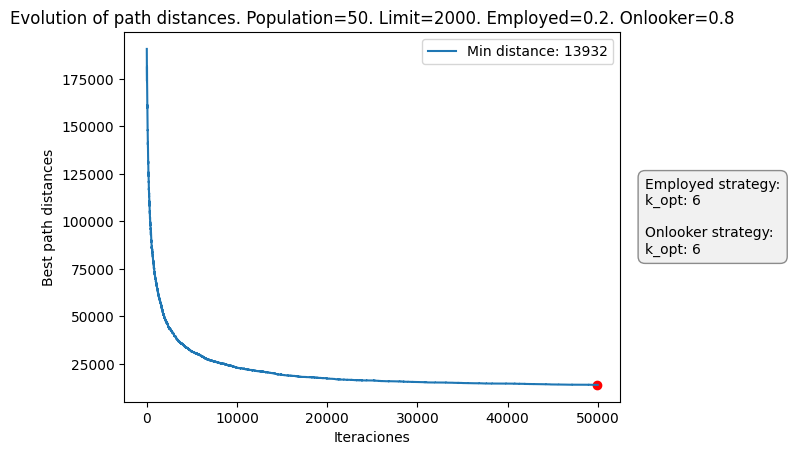

In [52]:
title = f'Evolution of path distances. Population={population}. Limit={limit}. Employed={employed_porcentaje}. Onlooker={onlooker_percentaje}'


history_best_paths_distances(paths_distances, employed_mutation_strategy + ": " + str(k_employed), onlooker_mutation_strategy+ ": " + str(k_employed), title=title)

Iterations 0-2999: Improvement of 150224.00 units of distance (78.73%)
Iterations 3000-5999: Improvement of 11259.00 units of distance (27.73%)
Iterations 6000-8999: Improvement of 4982.00 units of distance (16.98%)
Iterations 9000-11999: Improvement of 2931.00 units of distance (12.03%)
Iterations 12000-14999: Improvement of 2166.00 units of distance (10.11%)
Iterations 15000-17999: Improvement of 1239.00 units of distance (6.43%)
Iterations 18000-20999: Improvement of 1087.00 units of distance (6.03%)
Iterations 21000-23999: Improvement of 616.00 units of distance (3.64%)
Iterations 24000-26999: Improvement of 430.00 units of distance (2.64%)
Iterations 27000-29999: Improvement of 429.00 units of distance (2.70%)
Iterations 30000-32999: Improvement of 272.00 units of distance (1.76%)
Iterations 33000-35999: Improvement of 305.00 units of distance (2.01%)
Iterations 36000-38999: Improvement of 223.00 units of distance (1.50%)
Iterations 39000-41999: Improvement of 218.00 units of dist

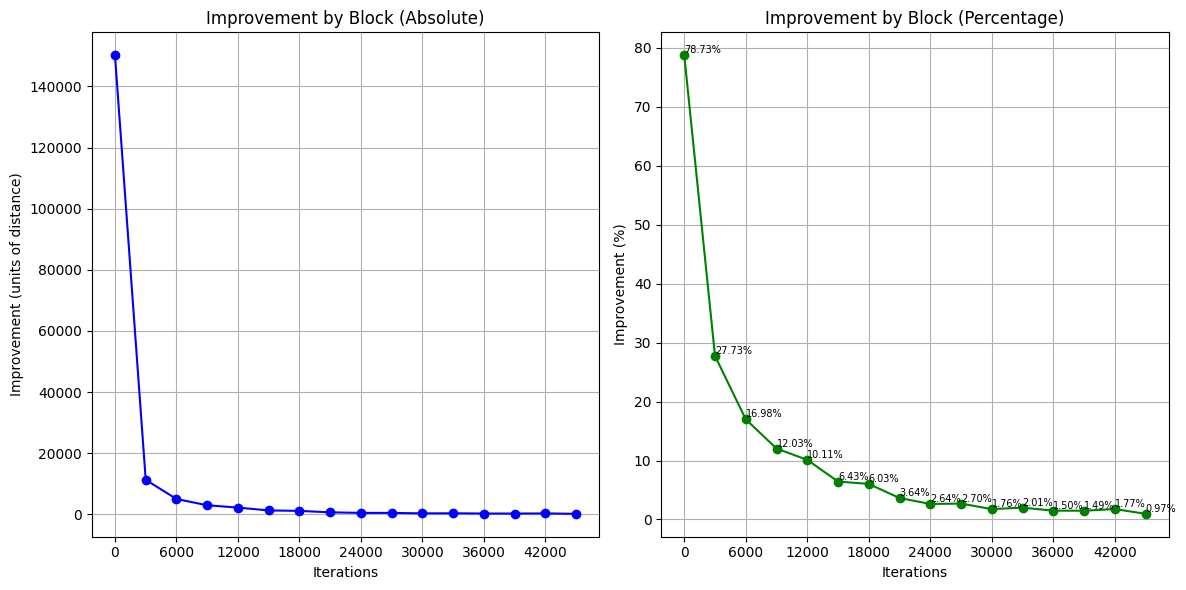

In [53]:
info_training(3000, paths_distances)

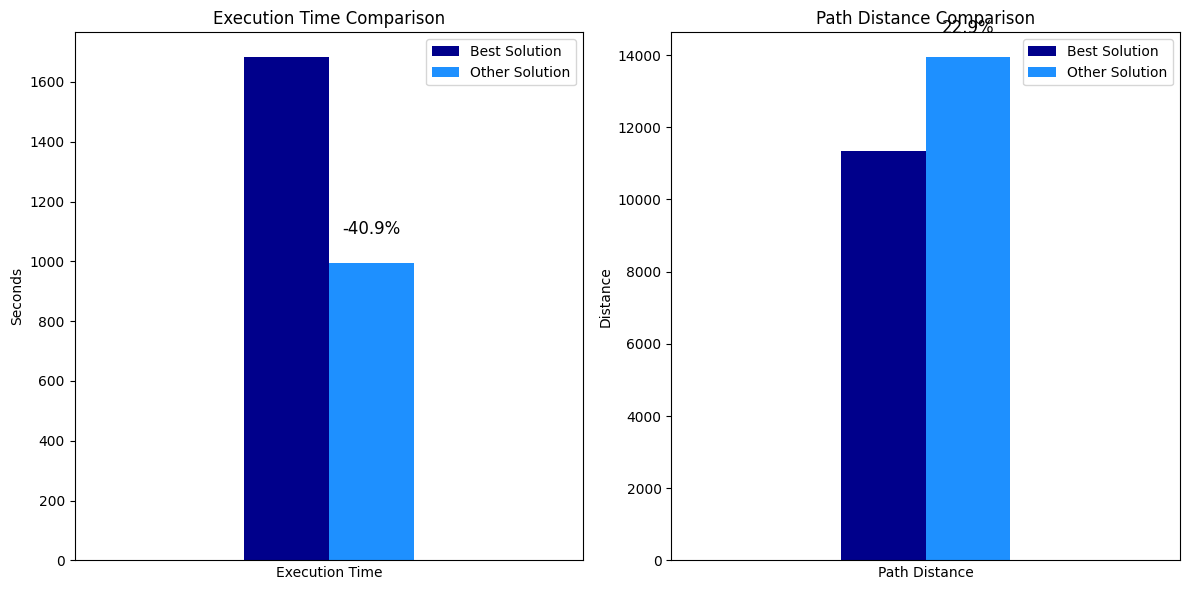

In [54]:
best_solution = [1681.68, 11340]
other_solution = [execution_time, final_best_path_distance]
plot_comparison(best_solution, other_solution)

### Find best hyper parameters

In [76]:
num_epochs = np.arange(5000, 60000, step=5000)
num_epochs

array([ 5000, 10000, 15000, 20000, 25000, 30000, 35000, 40000, 45000,
       50000, 55000])

In [77]:
ini_end_city = 0

populations = np.arange(25, 250, step=25)
employed_porcentaje = 0.2
onlooker_percentaje = 0.8
limit = 2000
num_epochs = np.arange(5000, 60000, step=5000)

employed_mutation_strategy = 'k_opt'    # swap, insertion, k_opt
onlooker_mutation_strategy = 'k_opt'    # swap, insertion, k_opt
num_k = np.arange(4, 15)

num_experiments = len(populations) * len(num_epochs) * len(num_k)
print(f"Number of experiments: {num_experiments}")

Number of experiments: 1089


Training Progress: 100%|██████████| 5000/5000 [00:13<00:00, 380.98epoch/s]


Params:
	(ini_end_city=0, population=25, epochs=5000, limit=2000, employed_percentage=0.2, onlooker_percentage=0.8)

Min path distance:  39226
The best path found is: 
 [  0 595 380 600  39 258 484 311 142 422 526 624   1 515 126 178 443 451
 182 127 502 550 350 305   5 611 146 325 562 586 596 407 181 334 150 398
 481 248 163 360 293  91 569 575 493 625 453 429 271 322 101  96 233 417
 378 225  46 137 241 612 329 519 477 261 482   8 463 119 523 257 310 314
 520 406  78 431 592 323 622 317 603 391 444 618 136 631 500 123 448 474
 353 541 176 457 623 479  26 215   6 308 280 269  65 195 499 238 284 628
   2 250  41 604 434 383 435 436 242  77 534 563 231 416 113 602  48  47
 584 609 549  20 236 574 116 410  34 447 587  31 265 290 355 478 553 395
  49 589  45 369 370 228 187 161  32  28 363 197 556 177 362 461 430 217
 487 408  35  74 340 449 561 354 124  14 208 204 594 365 108 555 206 542
 472 315 312 599 120 144 135 141 282 212 629 190  22 348 421  13 270 531
 385  30 375 285 172  12 508

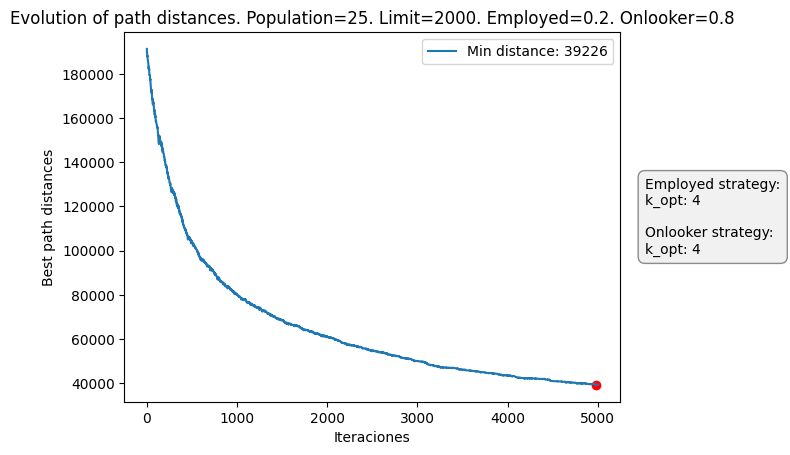

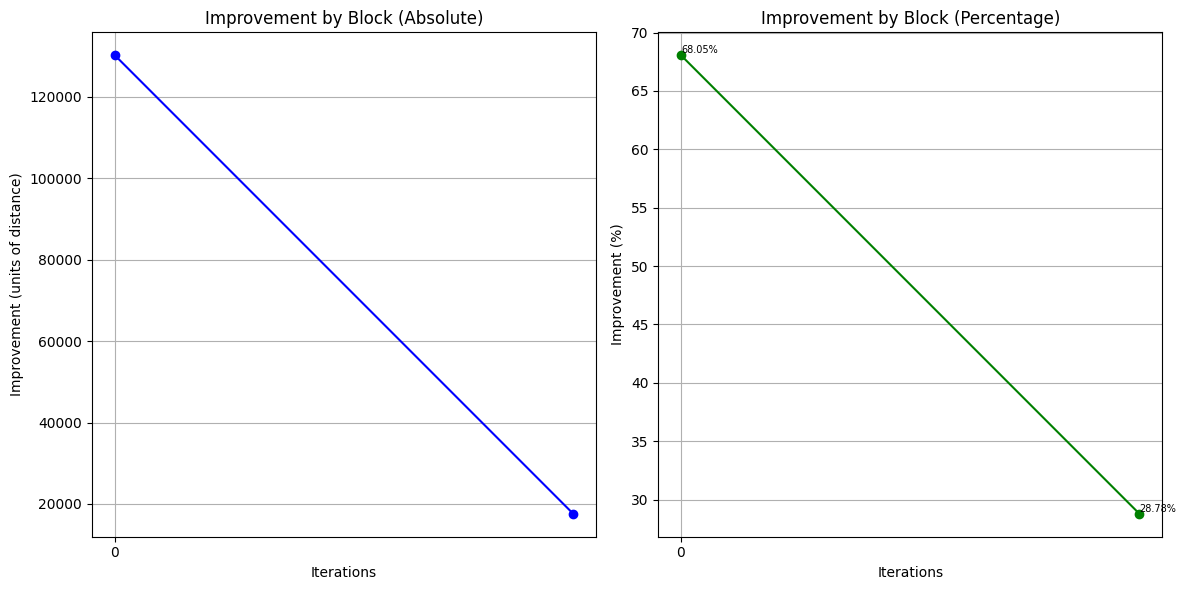

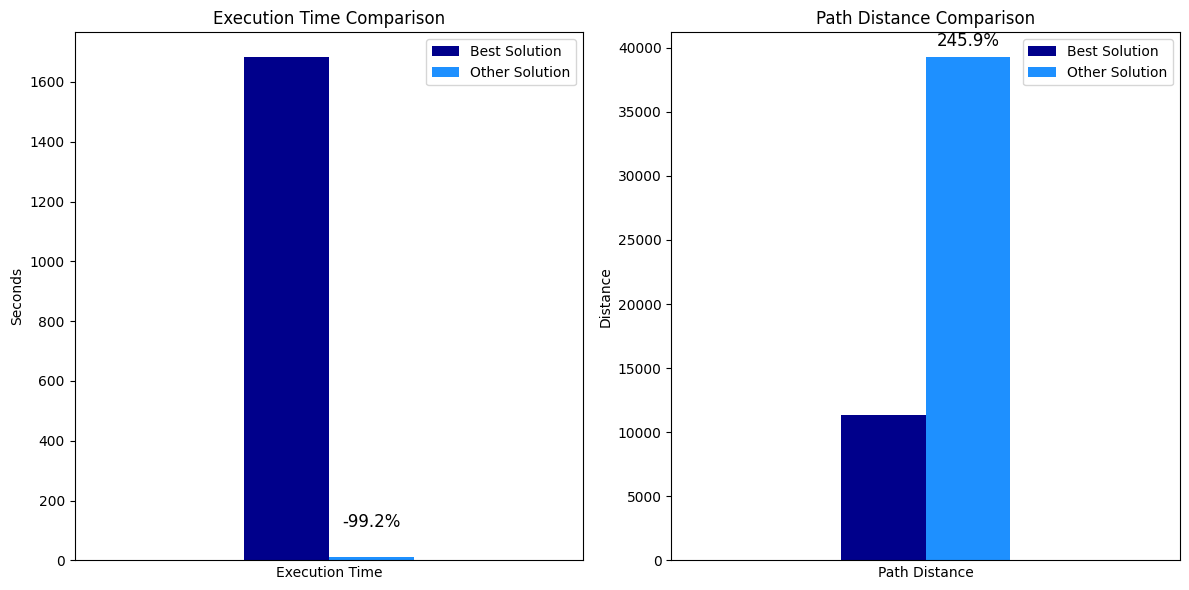

Training Progress: 100%|██████████| 5000/5000 [00:24<00:00, 201.02epoch/s]

Params:
	(ini_end_city=0, population=25, epochs=5000, limit=2000, employed_percentage=0.2, onlooker_percentage=0.8)

Min path distance:  35778
The best path found is: 
 [  0 595 593 427 454 274 133 167 528 277 342  39 485 600 410 578  17 161
 369 251 424  32 266 328 415 504 505 573 147 214 598 621 307 468 110 187
 419  24 525 247 537 432 186  37 556 371 470 230 259  54 149 140 324 452
 320 264 615 292 105 613 553 170 227 169 567 268  87 359  28 606 461 197
  35 221  10 254 206 626 330 379 185 408  23 363 581 395 104 501 263 487
 362  60 507 449 570 298 260 633 396 428 252 199 204 565 286 327  89  84
 403 460  67 568 594 542 521 572 473 397  51 164 143  93  78 494 314 120
 364  95 121 439  53 536 560 318 213 425 128 200 496 489 180 135 520 100
 344 270 138 157 448 300 240 513 310 141 605 190  22 174 294 212 629 455
 282 131  40 209 108 106 365  71 321  63 561 545 124 486 287 472 171  69
 336 509  25 355  18 333 313 540  14 208  36 394 411 555  11 522  59 506
 571 503 368 265 587 218 316

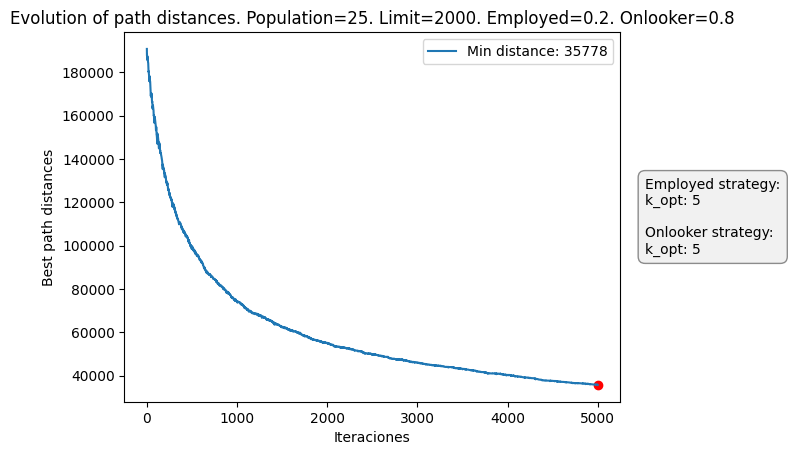

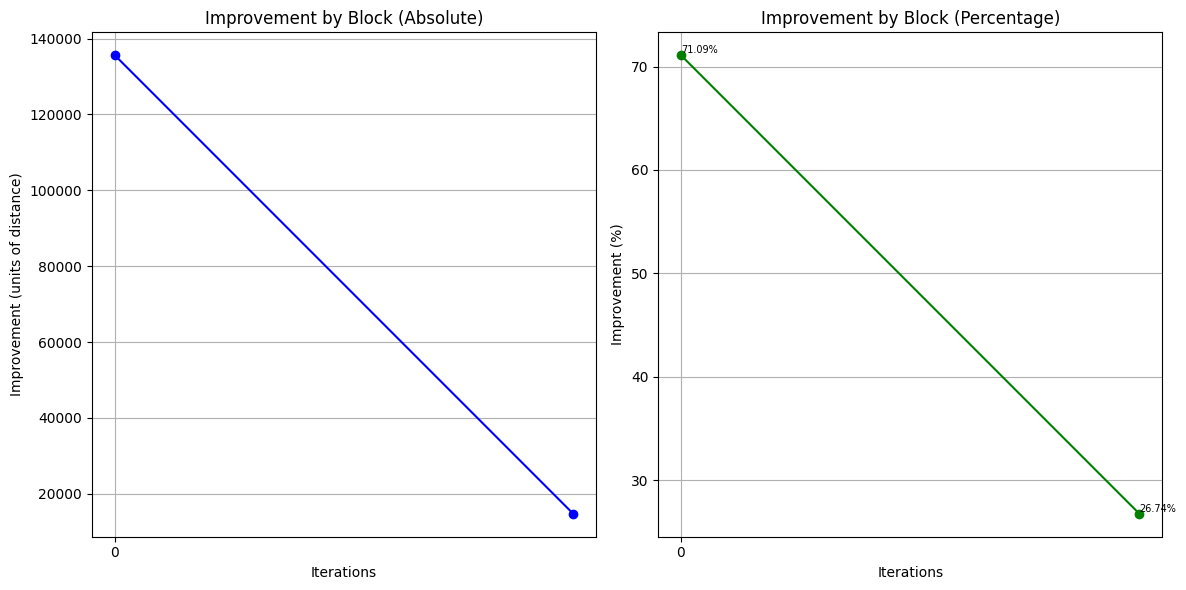

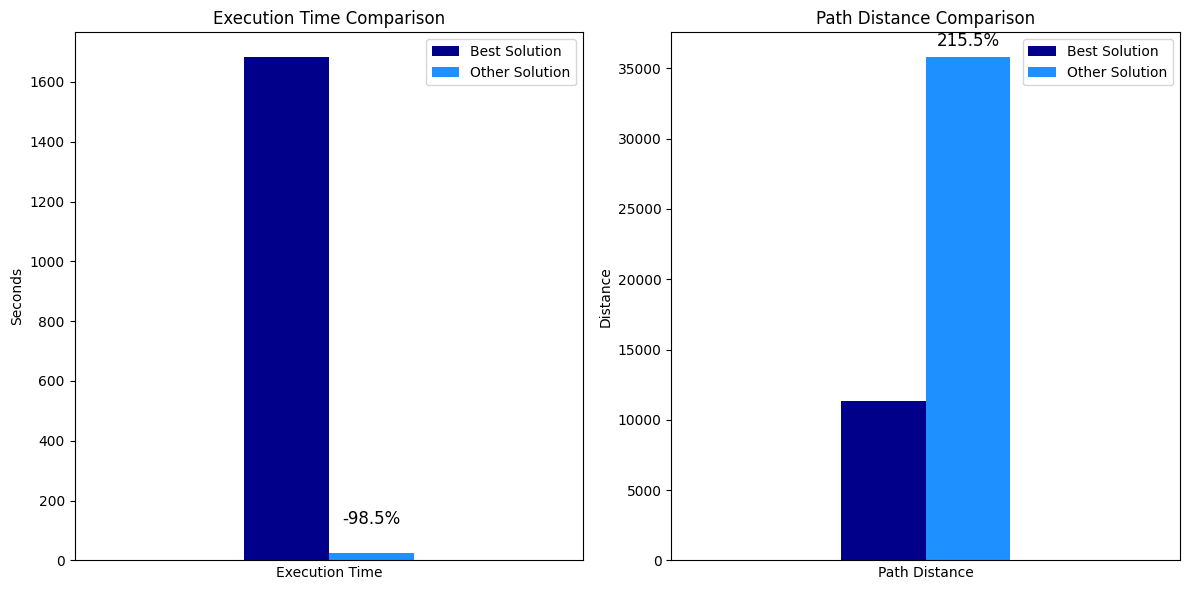

Training Progress: 100%|██████████| 5000/5000 [00:48<00:00, 103.72epoch/s]


Params:
	(ini_end_city=0, population=25, epochs=5000, limit=2000, employed_percentage=0.2, onlooker_percentage=0.8)

Min path distance:  31897
The best path found is: 
 [  0 595 163 239 125 525 468  18  64 413  90  80 598 533 211 156 476 222
 396 249 384 552 315 535 273 351 312 175 561 130 614 449 245 594 260 354
 619  92 409 220 392 164 154 115 517 418 204 199 298 565 472 480 327 486
 303  87 503  10 408 487 376 551  28 461  23 606 567 452 395 306 501 197
 362  16 177 118 328  54 149  37 371 470 556 301 122 379 221 522 394 571
 287 506 518  89 330 432 336 147 473 252 397  69 572 615 114 333 504 227
 537 247 193 530 110 307 274 390 234 172  86 508 332 404 378 182 426 443
  41 434 534 435 238   6 215 502   2 628  65 499 387 305 532 151  82  46
 477  27 134 479  26 558 632 329   9 357 302 111 617 137 490   7  61 457
 519 241 402  33 401 618 136 317 276 623 488 538 112 612 491 462 152  94
 420 493 352 417 159 367 482 583  31 342 153  48 609 515 126  77 383 436
 563 178 280 250  38 350 562

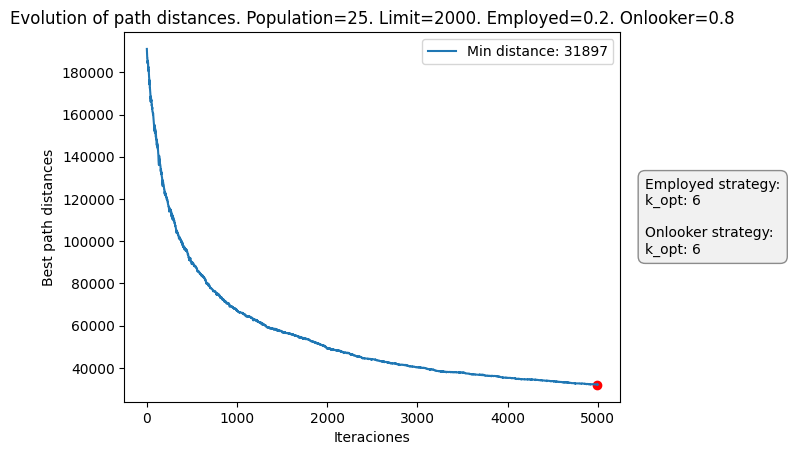

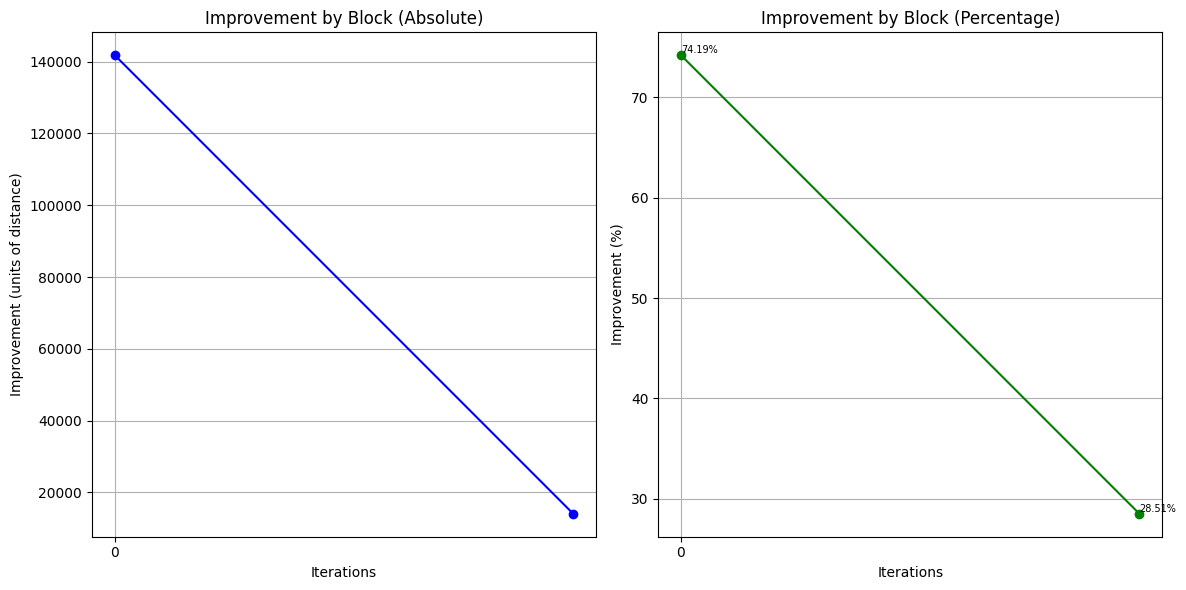

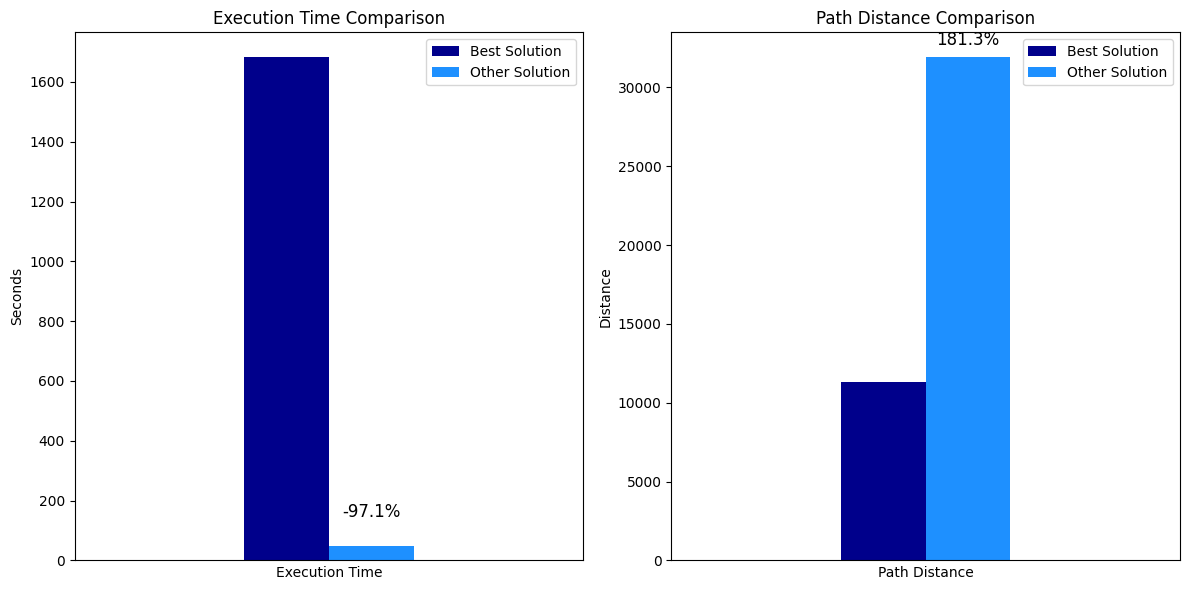

Training Progress: 100%|██████████| 5000/5000 [01:34<00:00, 52.97epoch/s]


Params:
	(ini_end_city=0, population=25, epochs=5000, limit=2000, employed_percentage=0.2, onlooker_percentage=0.8)

Min path distance:  30107
The best path found is: 
 [  0 595 454 439 154 121 128 341  95  53 249 214  69 509 369 169 503  87
 259 149 415 297 324  54 363 461  16 430  35 522 394 472  37 480 572 409
 124 545  11 204  36 555 516 507  40 403 175  43 202 196 400 582 566 374
 130 131   4  63  71 450 173 299 120 610 188 216 512 494  78 510 421 399
 103 382 441  83 381  76 223 489  93 557 536 326 414 143 155 366 392 281
 272 312 245 160 619 298 260 633 286 254  25 247 187 110  42 307 267 163
 237 625 322 544 562 611 405  39 116 600 447 468  98 355  18 333 248 239
 244 598 540 478 553 313  64 283 413 459 613 290 265  52 578  73  17 161
 303 264 186 424 194 368 170 504  49 320 573 626 230 266 268 452 359 581
 376 309 551  23 362 177 217 197 301 106 627 185 209  60 408 379 221  10
  74 487 616 328 227 505 567 140 139  32 251 228 347 395 306 606  28 104
 501 263 122 118  56  59 287

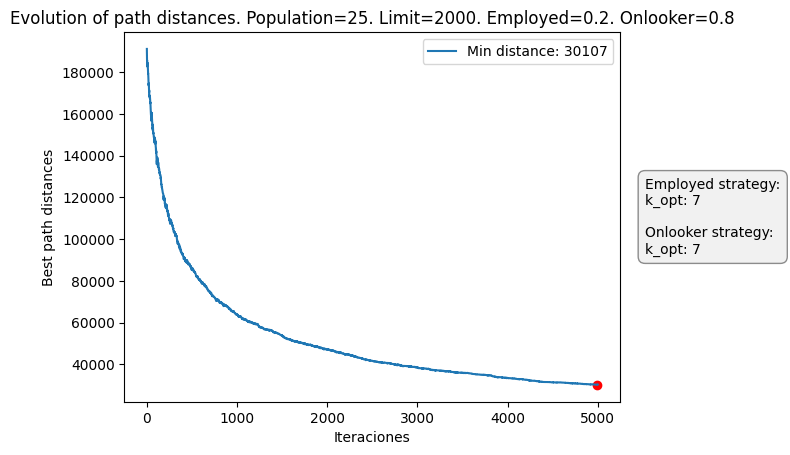

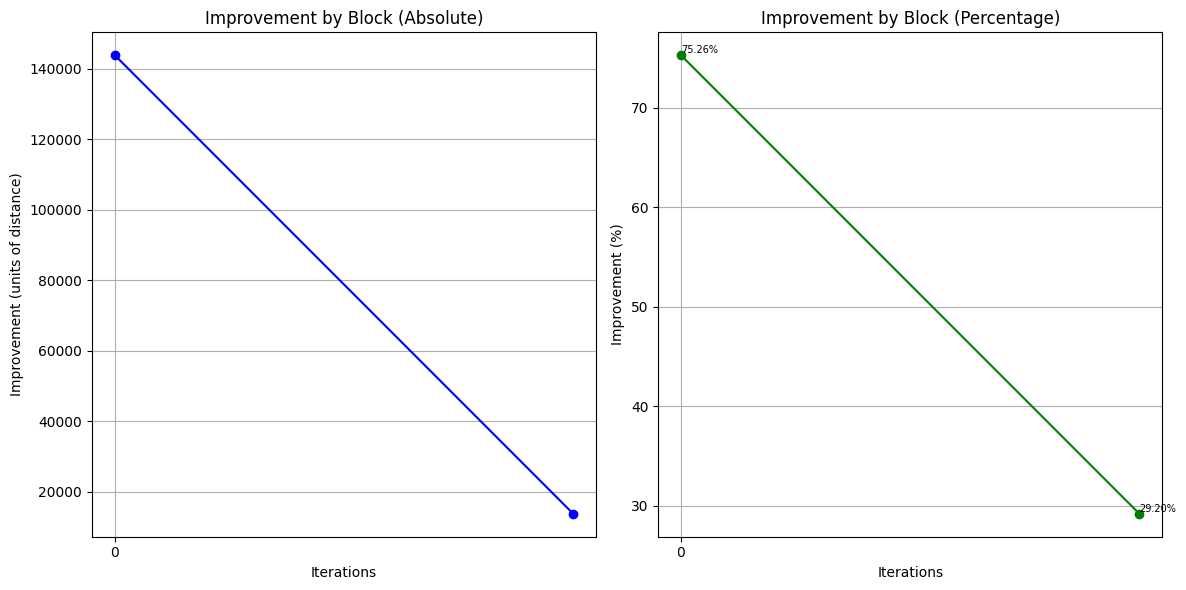

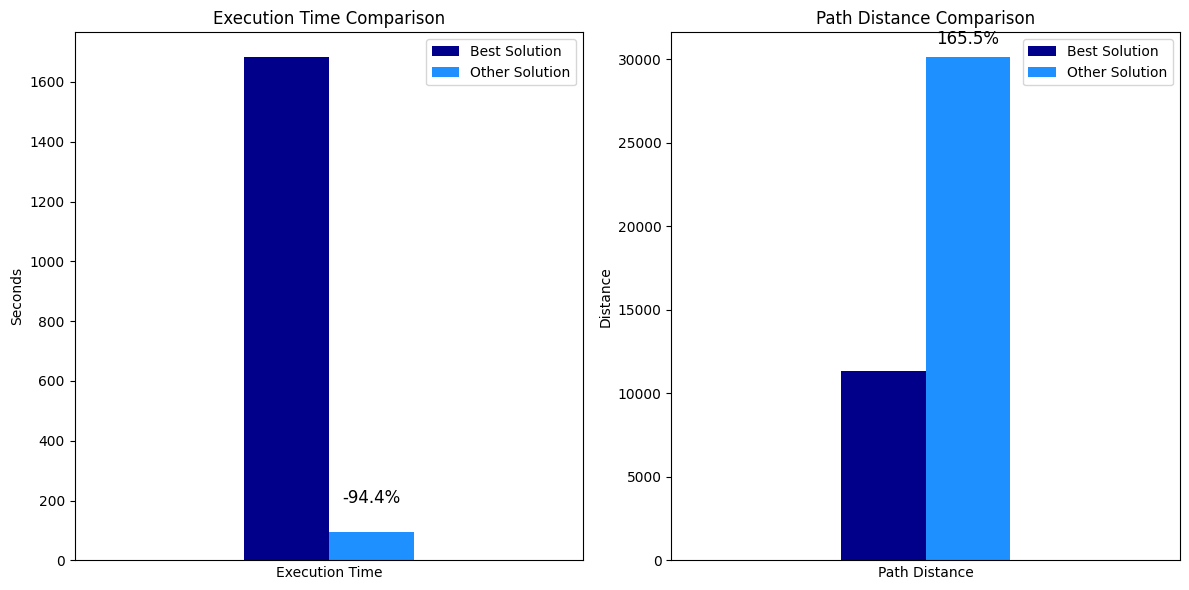

Training Progress: 100%|██████████| 5000/5000 [03:10<00:00, 26.26epoch/s]


Params:
	(ini_end_city=0, population=25, epochs=5000, limit=2000, employed_percentage=0.2, onlooker_percentage=0.8)

Min path distance:  27011
The best path found is: 
 [  0 554  13 319 548 427 601 162 226 332 285 495 234 375 527  29 531 138
 270 498 157 510 296 591  19 465 391 603 579 276  33 402  46 519  27 558
  82   2 302 426 477  99 184 523 456 378   8 463 404 564 352 622 464 444
 457 618  70 257 235 261  61 137 617 134 585 195 628 420 632 112  94   9
 152  26 612 329 151 479   7 538 490 462 241 488 491 623 401 176 630 361
 541 631 543 500 317 136 119 385 442  30 417 367 429 279 159 198 422 550
 182 451 181 127 482 219 225  88  97 229  57 183 255 142 471 150 311 529
 405  48 609 584  47 258 600 380 218 355 187  42 478 412 351 155 115  51
 326 373 520 224  83 100 441 406 348 200 318  58 249 193 147 572  69 206
 521 428 396 473 384 354 565 220  81 475 148 476 222 262 124 542  14 522
  59 379 221  60 571 472 516 411 545 204 208 254 303 626 327  89  37 518
  35 408 487 616 104 217 430

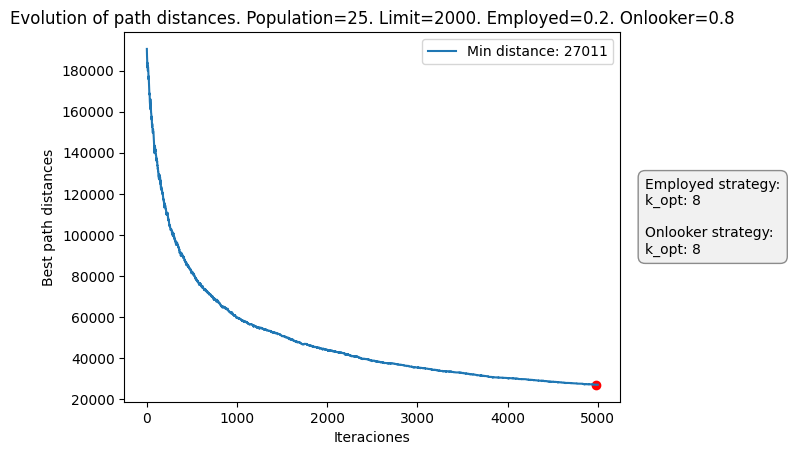

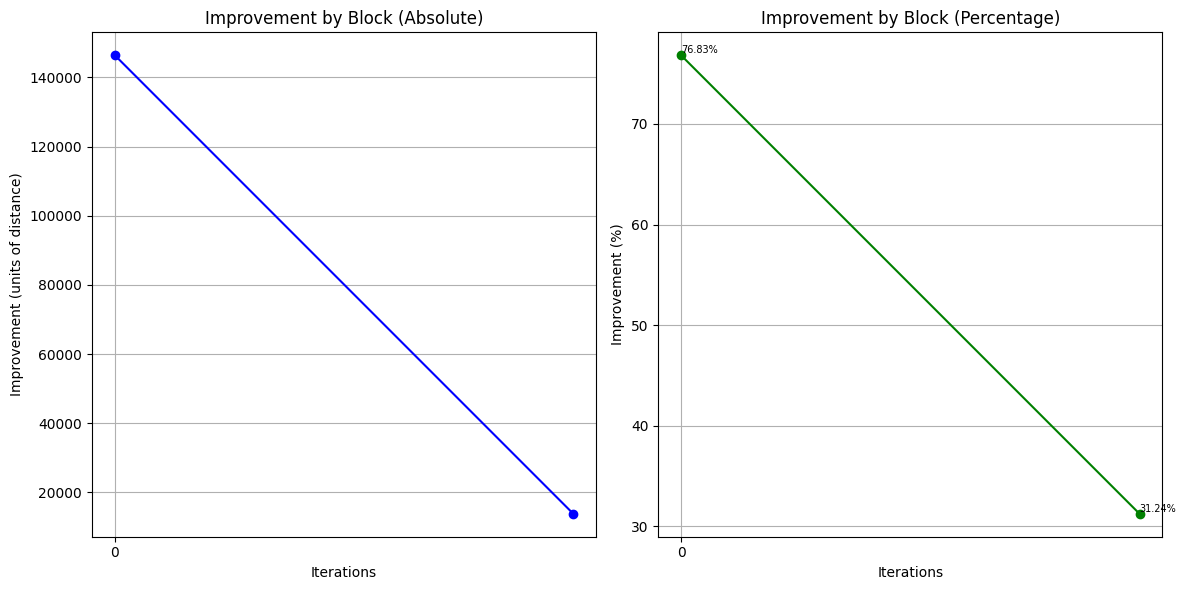

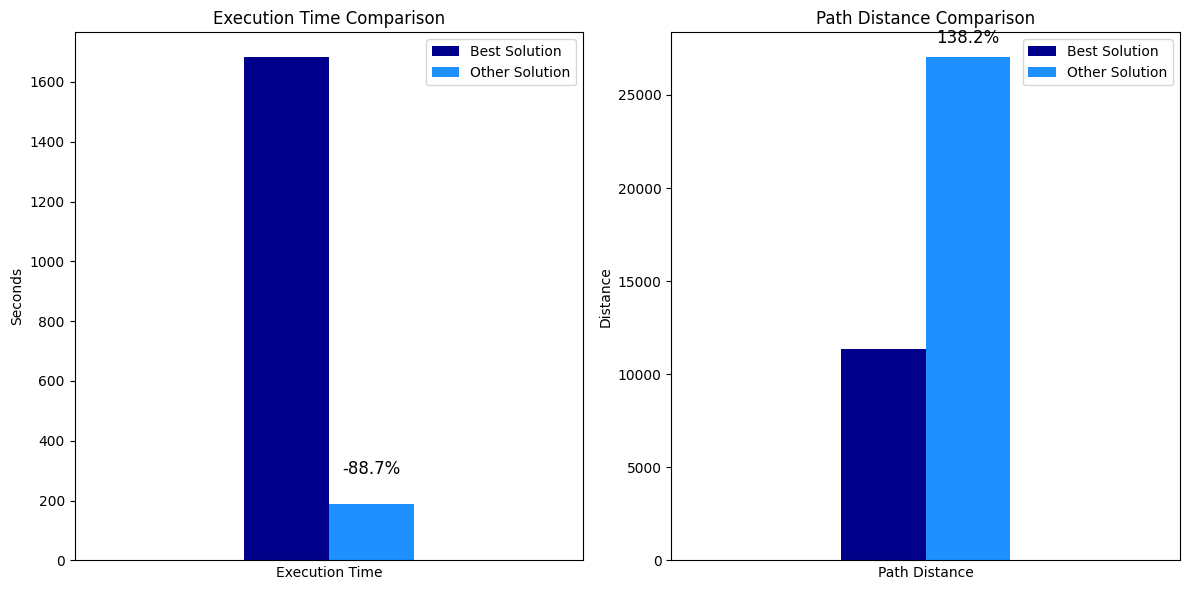

Training Progress: 100%|██████████| 5000/5000 [06:19<00:00, 13.16epoch/s]


Params:
	(ini_end_city=0, population=25, epochs=5000, limit=2000, employed_percentage=0.2, onlooker_percentage=0.8)

Min path distance:  25546
The best path found is: 
 [  0 441 213 314 135 141 174 144 282 310  22 212 513 190 629 117 294 191
 382 520 345 591 597 630 465 541 631 353 500 543 240 474 109 123 338  66
 203  79 498  19 448 361 391 276 579 176 588 291 253 285 295 234 495 508
 226 172  12  86 237 389 601 608 332 404 352 564 401 464 385 622 527 442
 162 417 463 235 261 225  88 183  97 229  57 219 429 482 356 271  21 453
 101 575 163 427 319 455  83  72 132 531 440 375  30 603 300 323  29 136
 317 444  70 257  33 119 456 367 198 159 559 625 255 142 550 471 146 325
 422 574 150 116  47 279 524   5 526 549 232 609 410 602 511 584 600 290
  68  45 149 452 140 567 268 210 368 466 589  52  64 613 437  31 447 342
 153 243 283  90 514 468 419 316   3 307 304 458 187 598 593 133 469  20
  96 322 236 386 607 586 451 334 182 127 349 433 583 398 484 258 481 493
 569  44 233 454 189  53 145

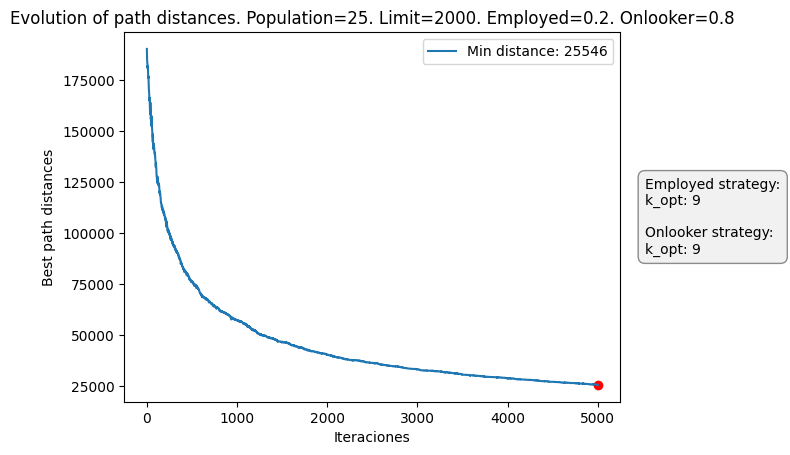

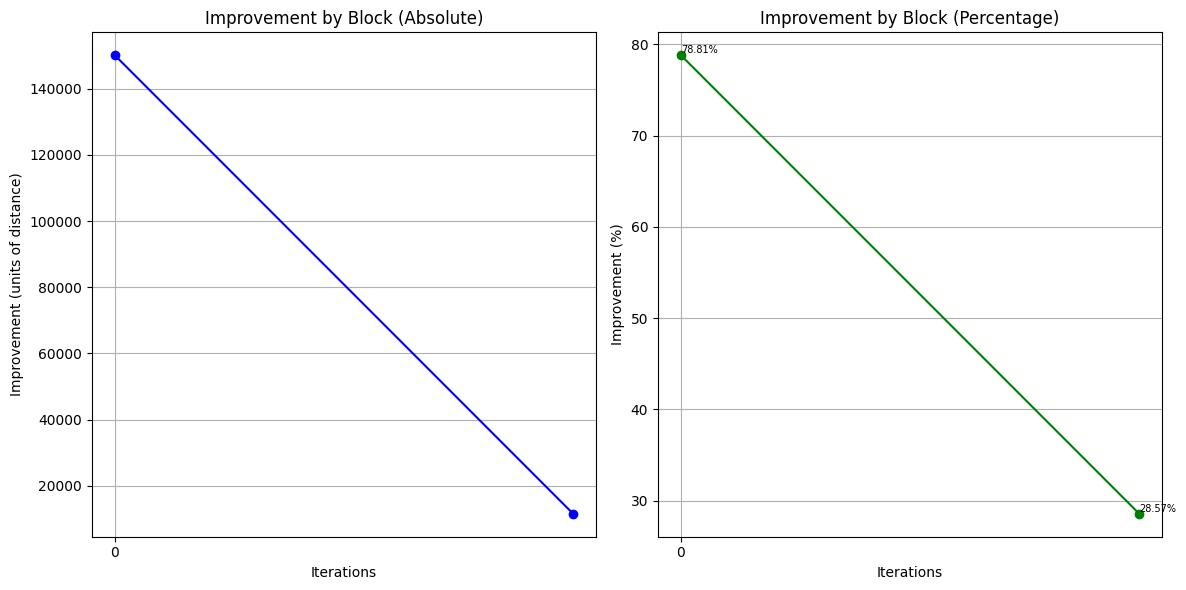

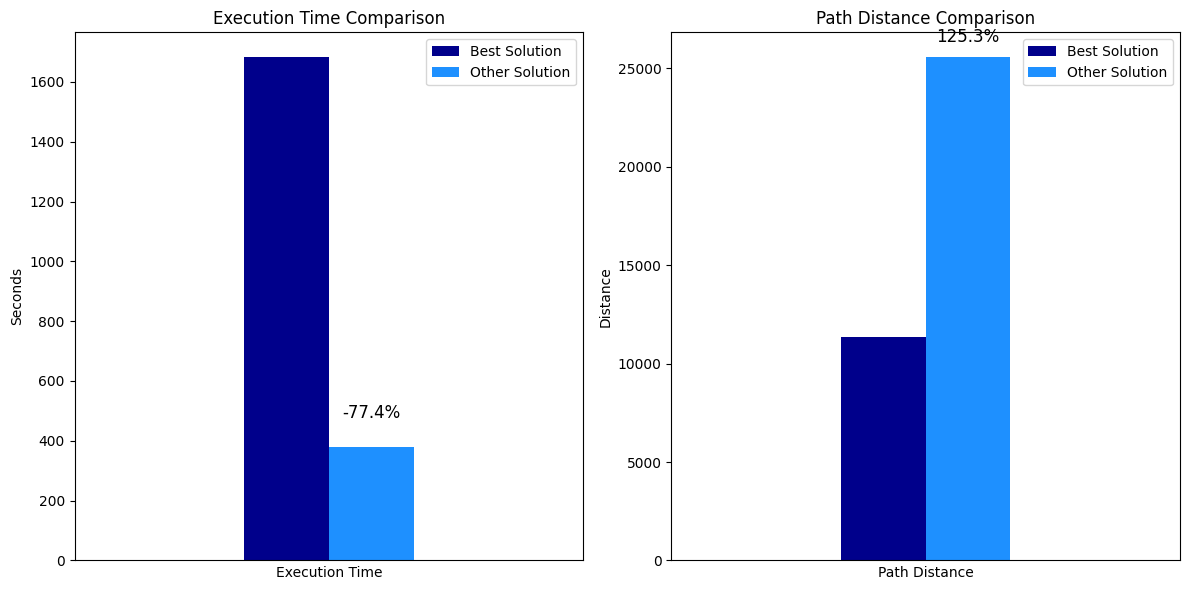

Training Progress: 100%|██████████| 5000/5000 [12:47<00:00,  6.51epoch/s]


Params:
	(ini_end_city=0, population=25, epochs=5000, limit=2000, employed_percentage=0.2, onlooker_percentage=0.8)

Min path distance:  23105
The best path found is: 
 [  0 554  13 337 620 547 326 536 121  58 560 180 344 373 157 498  19 107
 132 289  91 427 360 102 239 595 133 593 271 575 233  75 390 569 393  44
 219 229  97  57 255 471  65 443 215 502 628 426 302 420 479 558 617  27
 457 519 491 462 241 488 623 257 235 184 261 378  30 162 226 172 527 404
 442 564 531 591  83 100 224 212 513 190 282 135 141 310 144 314 510 138
 117 605 191 520 382 348  76  93 494 512 312 202  43 160 374 129 450   4
 175 400 131 173 196 216 278 492 299 120 423 455 629 296 168 448 240 497
 483  22 294 174 213 441 345 425 128  72 592 300 361 323  29 603 464 352
  70 618 444 391 631 500 630 317 276 401  33 402 440 375 285 295 234  12
 508 495 601 548 256 335 608 356 493  96 159  88 198 225 343 195 416 284
 165  38 269 387 280 178 308  77 126 436 383 534 242 250  41 563 435 515
   6 434 238 231 305 604 438

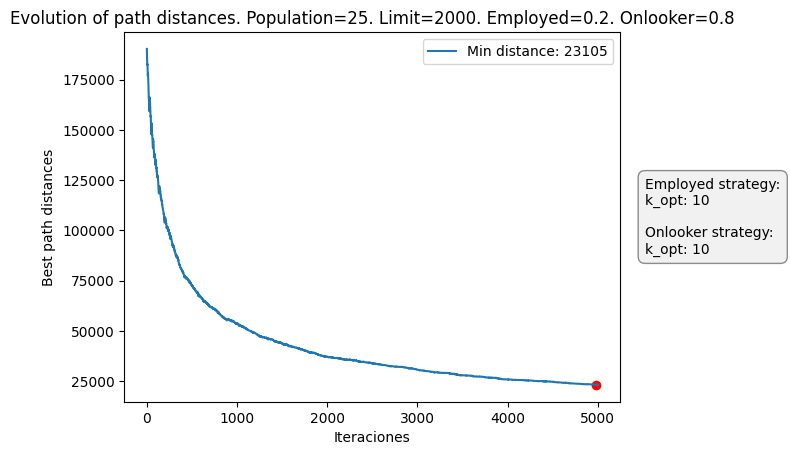

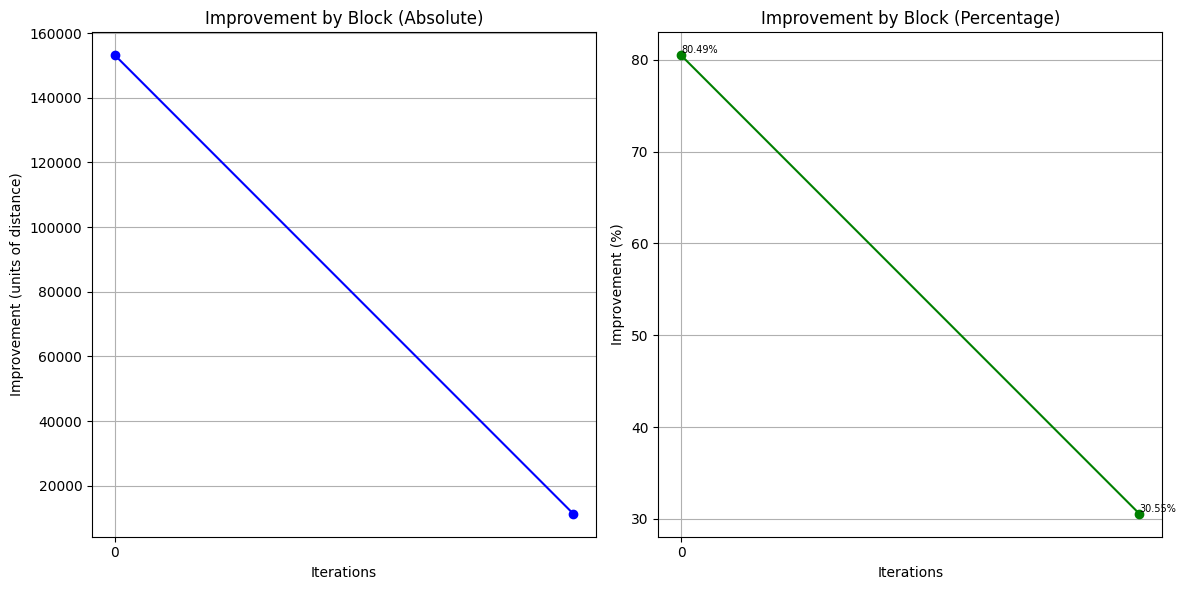

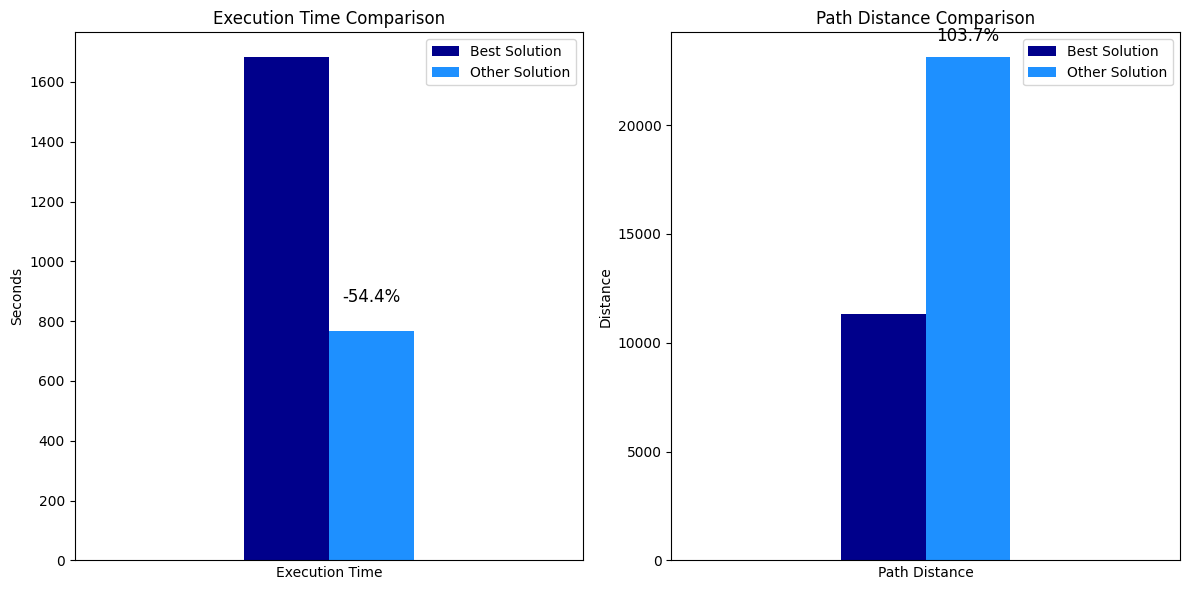

Training Progress: 100%|██████████| 5000/5000 [26:11<00:00,  3.18epoch/s]

Params:
	(ini_end_city=0, population=25, epochs=5000, limit=2000, employed_percentage=0.2, onlooker_percentage=0.8)

Min path distance:  22273
The best path found is: 
 [  0 595 593  53 557 115  51 246 189 517 473 396 521 206 105 210 313 292
 247 540 419 530  42 214 193 249  24 598 525 468 355  18 478 514  64 613
 459 218  52 445 466 589 265 290  31  90  80 125 304 580 133 481 248  20
 453 469 316 192 244 239 554 285 564 119 463 225 183  99  97 198 219 482
   8 261 235 184 477  61 457 402  70 352 442 404 162 159 367 101 293 163
 427 360  91 274 307 458 187 110 572 428 542  14 204 486 626 303 320 372
 432 336 114 333  45 553  25 615 264 339 397  69 147 171 222 476 252 412
 154 351 535 475 160 245 582 561 614 449 403 460 570 298 260 199  62  84
 365  67 507 106 411 516  59 408 616 576 430  23 309 395 324 452 359 415
 140 504 369 509 537  87 169  15 254 327 480 208 340 286 315 539 619 288
  92 281  81 446 366 599 202 278 492 272 312 129  43 321  50 566   4 175
 400 131 130  71  63 450 374

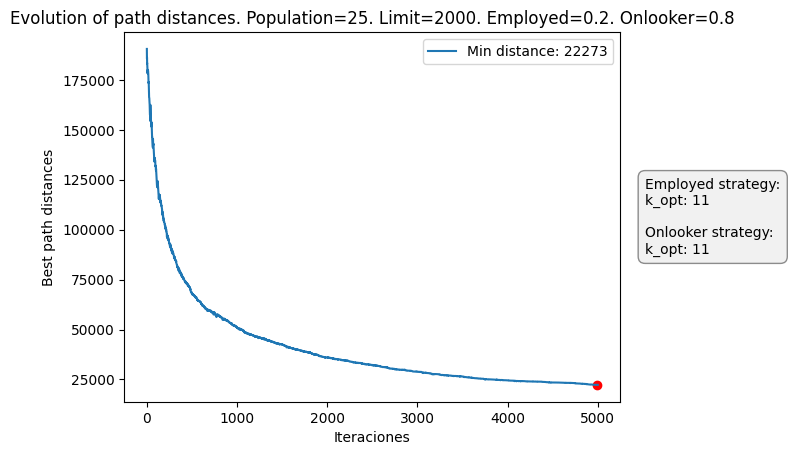

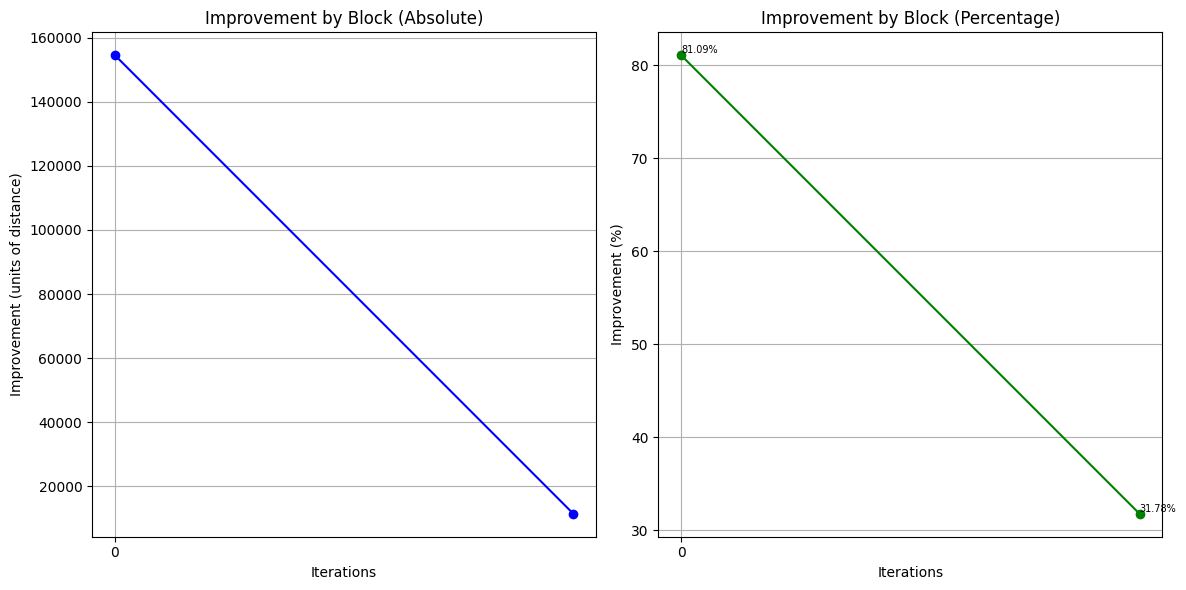

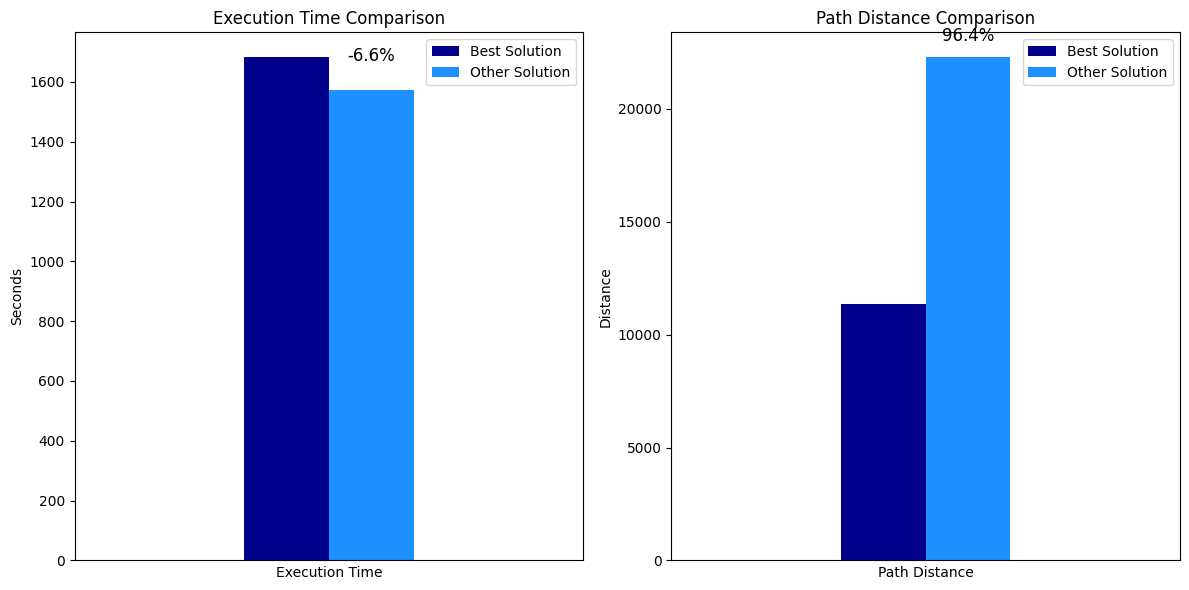

Training Progress: 100%|██████████| 5000/5000 [54:25<00:00,  1.53epoch/s]

Params:
	(ini_end_city=0, population=25, epochs=5000, limit=2000, employed_percentage=0.2, onlooker_percentage=0.8)

Min path distance:  21703
The best path found is: 
 [  0 441 455 510 498 497 109  19 448 474 240 117 174  22 282 310 141 144
 135 629 212 513 190 483 100 345 337 608  44 601 393 569 233  75 360 289
 237 102 580 239 595 192 447  90 218 437  80 355  17 161  73 578  55 194
 139 368  49  32 186 615 264 509 252 189 246 536 377 560 425 275 341  95
 439 421 373 344 180 431  85 399  76 489 358 364 207 496 533  93 610 156
 211  43 321  81 366 202 196 272 120 494 381 103 318 406 348 331  78 128
 200 132  29 352 523 491  27 137  61 477 261 463 159 198 367  88 219 429
 482 422 529  47 325 146 386 549 524 410  34 602 308 242 305 269  65 231
 443 416 250 284 628   2 502 215 195 165 604 387 534 434   6  41 238 563
 435 515 436 383 126  77 499 178 280 438 611   5   1 546 388 624 181  97
 229 225 183 142 471 334 182 127  57 255 585 343 451 544 596 407  38 577
 350 562 586 550 607 349 279

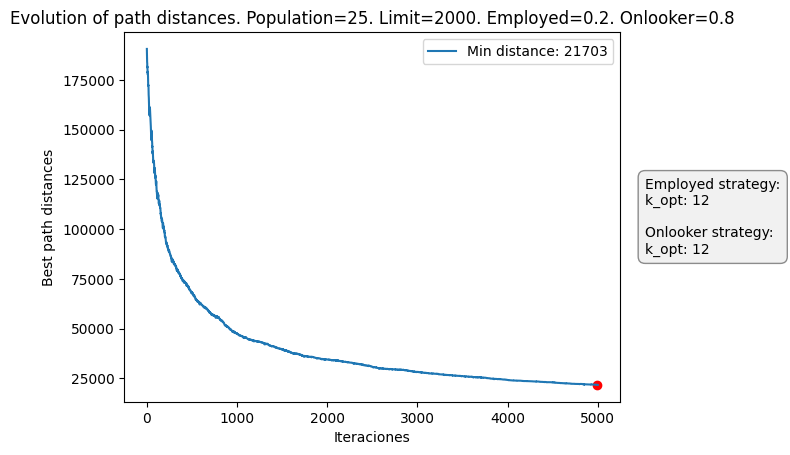

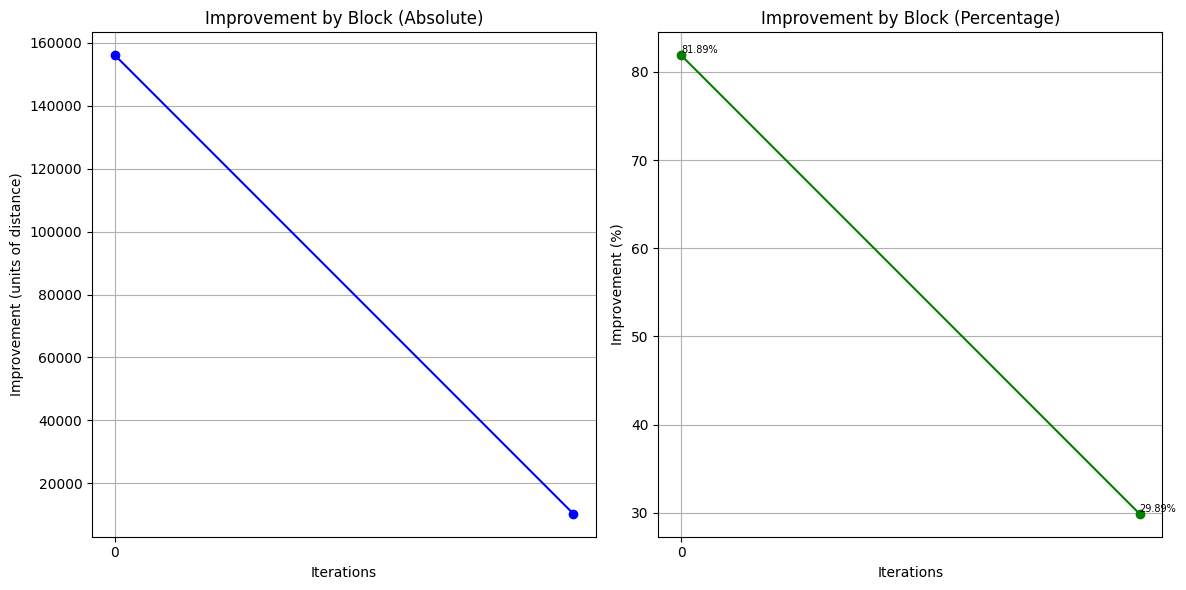

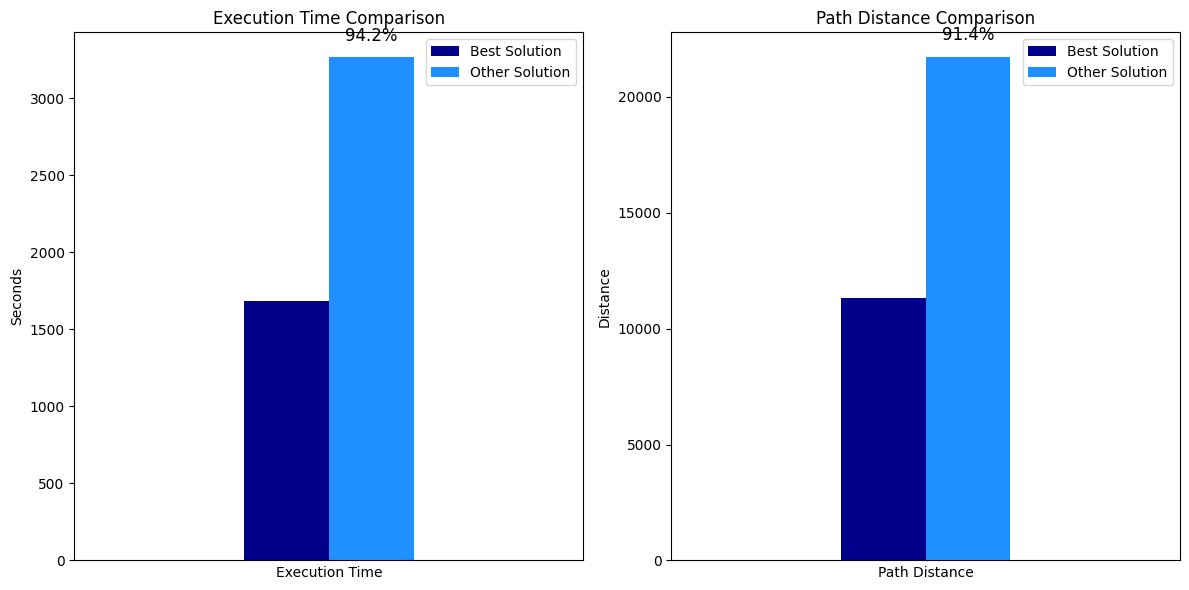

Training Progress: 100%|██████████| 5000/5000 [1:51:22<00:00,  1.34s/epoch]

Params:
	(ini_end_city=0, population=25, epochs=5000, limit=2000, employed_percentage=0.2, onlooker_percentage=0.8)

Min path distance:  20013
The best path found is: 
 [  0 441 382 348 423 381  76 345 431 373 510 591 296 448  19 157 498 497
  79 109 338 353 543 500 631 391 276  33 352 523 261  70 623 618 444 402
 457 241 488 538 112 152 490 477 257 235 119 378 482 429 198 367 159 493
 417 271  21 219 229  57 343 426 302 502 215 195 544 451 181 334 182 127
 255  99 184  97 183  88 225   8 463 456  30 564 442 385 464 603 176 291
 588 592 344 270 520 213 135 120 299 492 202 272 173 196 216 188 512 599
 156 211 358 205 364 207 489 467  53  51 246 249 517 412 164 346  50 475
 446 281 366  43  92 160 321 312 129 374 175 131 400   4 450 288 245 582
 449 614 561 566 130  71 403  63 460 365  67  40 594  84 108 209 106 516
  60 394 506 518  37  15 327 330 571  10 287  74 221 379 408  35 487 576
 197 217 177 501 430 104 362  16 328 149 259 470 371 122 616 118  56 263
 581 551 359  54 415 452 324

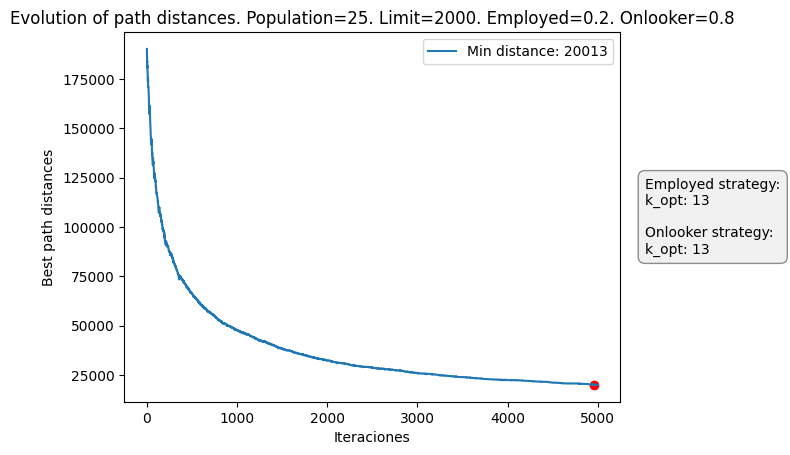

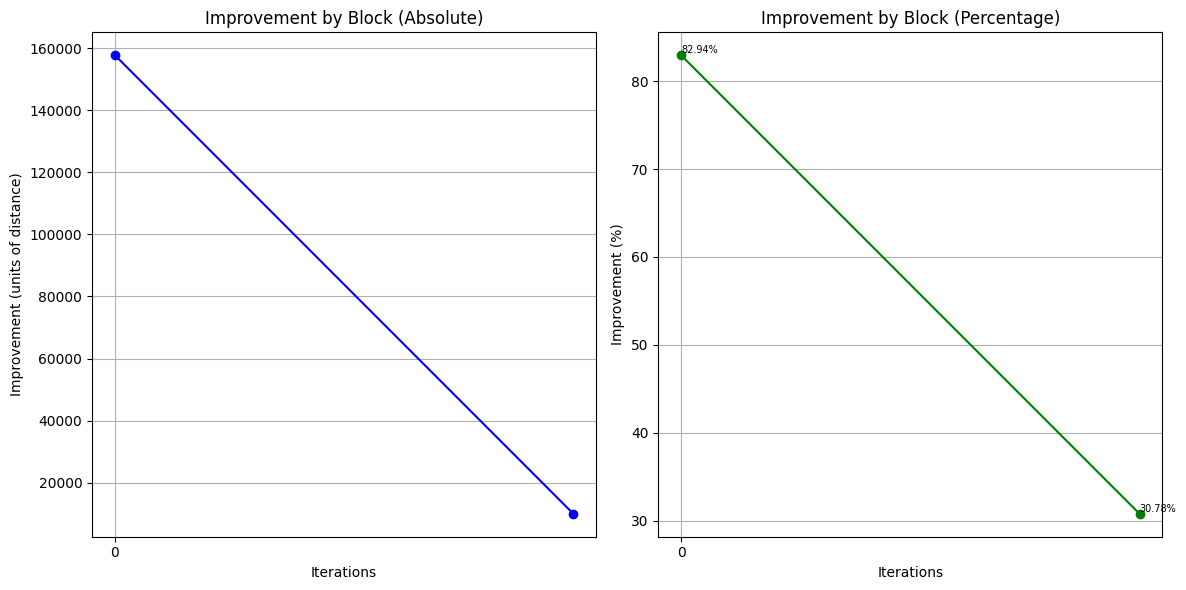

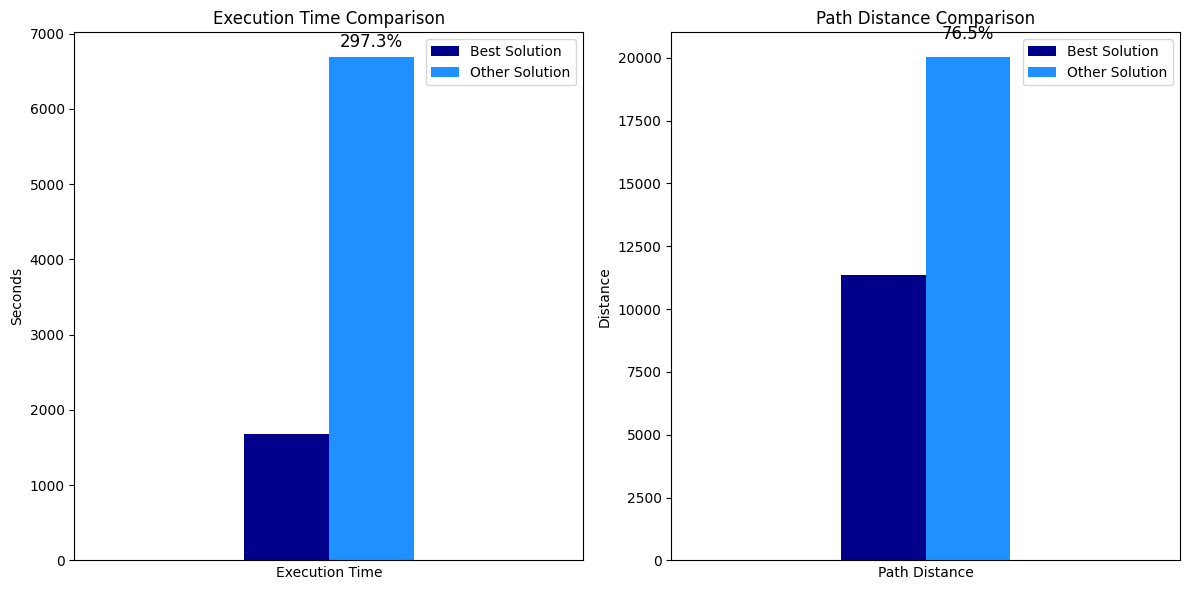

Training Progress:  19%|█▉        | 954/5000 [43:31<3:04:36,  2.74s/epoch]


KeyboardInterrupt: 

In [78]:
for population in populations:
    for epochs in num_epochs:
        for k_employed in num_k:
            k_onlooker = k_employed

            ABC = ArtificialBeeColony_TSP.ArtificialBeeColonyOptimizer(ini_end_city, population, employed_porcentaje, limit, epochs, distance_matrix, 
                                                           employed_mutation_strategy, onlooker_mutation_strategy, k_employed, k_onlooker)

            execution_time, paths_distances, final_best_path, final_best_path_distance = ABC.fit()
            
            title = f'Evolution of path distances. Population={population}. Limit={limit}. Employed={employed_porcentaje}. Onlooker={onlooker_percentaje}'
            history_best_paths_distances(paths_distances, employed_mutation_strategy + ": " + str(k_employed), onlooker_mutation_strategy+ ": " + str(k_employed), title=title)

            info_training(2000, paths_distances)

            best_solution = [1681.68, 11340]
            other_solution = [execution_time, final_best_path_distance]
            plot_comparison(best_solution, other_solution)

In [ ]:
ini_end_city = 0

population = 50
employed_porcentaje = 0.2
onlooker_percentaje = 0.8
limit = 2000
epochs = 10000

employed_mutation_strategy = 'k_opt'    # swap, insertion, k_opt
onlooker_mutation_strategy = 'k_opt'    # swap, insertion, k_opt
k_employed = 9
k_onlooker = 9


In [ ]:
history_best_paths_distances(distances_experiments, xlabel='Num experimets', ylabel='Best distance')

NameError: name 'distances_experiments' is not defined

In [ ]:
paths, paths_distances, final_best_path, final_best_path_distance = min(results_best_hiperparameters, key=lambda x: x[-1])
history_best_paths_distances(paths_distances, title='Evolution of path distances best hiperparameters version_mutate=2')

In [ ]:
# Save all best combinations
array_results_best_hiperparameters = np.array(results_best_hiperparameters, dtype=object)
np.save('All_best_results_hiperparametes_combination_mutathed_version_2.npy', array_results_best_hiperparameters)

# Save best hiperparameters combination
with open('Best_hiperparametes_combination_mutathed_version_2.txt', 'w') as f:
    f.write('Best hyper-parameters are : population=170, employed_porcentaje=0.2, onlooker_percentaje=0.8, limit=80, epochs=2200.\n')